In [2]:
#import necessary module
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import sys
import math

conf = SparkConf().setMaster('local[1]').setAppName('my app')
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.appName('bda-project').getOrCreate()

In [57]:
#defining schema
schema = StructType([
    StructField("adult", StringType(), True),
    StructField("belongs_to_collection", StringType(), True),
    StructField("budget", FloatType(), True),
    StructField("genres", StringType(), True),
    StructField("homepage", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("imbd_id", IntegerType(), True),
    StructField("original_language", StringType(), True),
    StructField("original_title", StringType(), True),
    StructField("overview", StringType(), True),
    StructField("popularity", FloatType(), True),
    StructField("poster_path", StringType(), True),
    StructField("production_companies", StringType(), True),
    StructField("production_countries", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("revenue", FloatType(), True),
    StructField("runtime", FloatType(), True),
    StructField("spoken_language", StringType(), True),
    StructField("status", StringType(), True),
    StructField("tagline", StringType(), True),
    StructField("title", StringType(), True),
    StructField("video", StringType(), True),
    StructField("vote_average", FloatType(), True),
    StructField("vote_count", FloatType(), True), 
])

data = spark.read.csv('../PySparkWork/data_project/movies_metadata.csv', header = True, schema = schema)

In [58]:
#defining json
jsonSchema = ArrayType(StructType([
    StructField("id", IntegerType()),
    StructField("name", StringType()),
    StructField("poster_path", StringType())
                 ]))
jsonSchema2 = ArrayType(StructType([
    StructField("id", IntegerType()),
    StructField("name", StringType())
                 ]))
jsonSchema3 = ArrayType(StructType([
    StructField("name", StringType()),
    StructField("id", IntegerType())
                 ]))
jsonSchema4 = ArrayType(StructType([
    StructField("iso", StringType()),
    StructField("name", StringType())
                 ]))
jsonSchema5 = ArrayType(StructType([
    StructField("iso", StringType()),
    StructField("name", StringType())
                 ]))

In [59]:
#data preprocess
data = data.fillna(0)
data = data.filter(col('adult').isNotNull() &
                     col('belongs_to_collection').isNotNull() &
                     col('genres').isNotNull() &
                     col('homepage').isNotNull() &
                     col('original_language').isNotNull() &
                     col('original_title').isNotNull() &
                     col('overview').isNotNull() &
                     col('poster_path').isNotNull() &
                     col('production_companies').isNotNull() &
                     col('production_countries').isNotNull() &
                     col('release_date').isNotNull() &
                     col('spoken_language').isNotNull() &
                     col('status').isNotNull() &
                     col('tagline').isNotNull() &
                     col('title').isNotNull() &
                     col('video').isNotNull()                     
                    )

data = data.withColumn("belongs_to_collection", from_json(data["belongs_to_collection"], jsonSchema))
data = data.withColumn("genres", from_json(data["genres"], jsonSchema2))
data = data.withColumn("production_companies", from_json(data["production_companies"], jsonSchema3))
data = data.withColumn("production_countries", from_json(data["production_countries"], jsonSchema4))
data = data.withColumn("spoken_language", from_json(data["spoken_language"], jsonSchema5))

In [60]:
data.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- poster_path: string (nullable = true)
 |-- budget: float (nullable = false)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- imbd_id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = false)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- id: i

### 1. Build regression models to predict movie revenue and vote averages based on a certain metric.

In [141]:
stages = []
categoricalColumns = ['adult', 'original_language', 'status', 'video']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
numericCols = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
assemblerInputs = [c + 'classVec' for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]


pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
vdata = pipelineModel.transform(data)
selectedCols = ['revenue', 'features']
vdata = vdata.select(selectedCols)
(training, test) = vdata.randomSplit([0.8, 0.2])

lr = LinearRegression(featuresCol = 'features', labelCol='revenue', maxIter=3, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(training)
prediction = lr_model.transform(test)
prediction.select("prediction","revenue","features")
prediction.sort(prediction.revenue, ascending=False).show(5)
trainingSummary = lr_model.summary
print("r2: %f" % trainingSummary.r2)

+------------+--------------------+--------------------+
|     revenue|            features|          prediction|
+------------+--------------------+--------------------+
|2.78796518E9|(299,[0,3,94,177,...| 6.474714579283264E8|
|1.51352883E9|(299,[0,3,94,177,...| 4.455929761569248E8|
|1.50624934E9|(299,[0,3,94,177,...|5.2226747289941514E8|
|1.10856102E9|(299,[0,3,94,177,...| 5.402405839199818E8|
|1.02006336E9|(299,[0,3,94,177,...|3.1017449421305764E8|
+------------+--------------------+--------------------+
only showing top 5 rows

r2: 0.569138


In [147]:
stages = []
categoricalColumns = ['adult', 'original_language', 'status', 'video']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
numericCols = ['budget', 'popularity', 'runtime', 'revenue', 'vote_count']
assemblerInputs = [c + 'classVec' for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
vdata = pipelineModel.transform(data)
selectedCols = ['vote_average', 'features']
vdata = vdata.select(selectedCols)
(training, test) = vdata.randomSplit([0.8, 0.2])

lr = LinearRegression(featuresCol = 'features', labelCol='vote_average', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(training)
prediction = lr_model.transform(test)
prediction.select("prediction","vote_average","features")
prediction.sort(prediction.vote_average, ascending=False).show(5)
trainingSummary = lr_model.summary
print("r2: %f" % trainingSummary.r2)

+------------+--------------------+------------------+
|vote_average|            features|        prediction|
+------------+--------------------+------------------+
|2.96655424E8|(299,[0,3,122,197...| 1.397639582453258|
|        84.0|(299,[0,15,173,18...| 93.64828261183598|
|         8.5|(299,[0,3,94,177,...| 6.000670724256101|
|         8.1|(299,[0,3,94,177,...|5.8651663949333175|
|         8.1|(299,[0,3,94,177,...| 5.837089447314992|
+------------+--------------------+------------------+
only showing top 5 rows

r2: 0.999644


### 2. Analyze that what movies tend to get higher vote averages on TMDB. Try to use more figures with data visualization methods to illustrate your analysis.

In [67]:
df = data.toPandas()

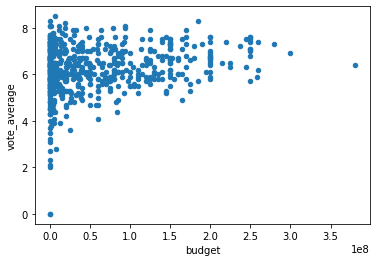

In [68]:
df.plot(kind='scatter',x='budget',y='vote_average')

###### This is a graph plotted with budget against the average of votes of the movies. It can be seen that movies with the highest vote average are surprisingly movies with lower budget. This indicates that high budget does not necessarily means higher average of vote. That said, the variances of vote average among the movies with low budget is high, so movies with low budget is that accurate of an indicator.

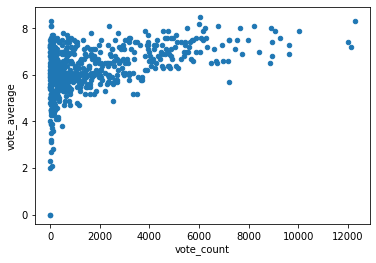

In [69]:
df.plot(kind='scatter',x='vote_count',y='vote_average')

###### This is a graph plotted with vote counts against the average of votes of the movies. The highest vote average here is the movies with around 6000 vote counts. The vote average of the movies with low vote count is also high in some of them but there are a wide variance among them. This means that the possiblity of a movie with low vote count getting low average of vote is not far from getting a high vote average.

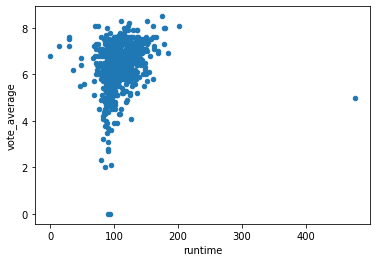

In [70]:
df.plot(kind='scatter',x='runtime',y='vote_average')

###### This graph is plotted with the variable runtime against the average of vote. It can be seen here that most of the movies has a runtime of 100-150. The highest vote average would be on the movie with around 180 runtime. Most of the movies with high average of votes are in 150. It can be stated that movies with around 150 runtime has a higher vote average. This could be due to the fact that the expectation of movie goers nowadays expect a runtime of around 2.5 hours in a movie 

### 3. Use collaborative filtering to build a movie recommendation system with two functions:
### a. Suggest top N movies similar to a given movie title

In [71]:
# defining functions for reading data and training als model
def get_ratings_df(ratings_path, spark):
    schema = StructType([
        StructField('userId', IntegerType(), True),
        StructField('movieId', IntegerType(), True),
        StructField('rating', FloatType(), True),
        StructField('timestamp', FloatType(), True)
    ])

    ratings_df = spark.read\
        .csv(ratings_path, header=True, schema=schema)

    return ratings_df


def create_model(train_df):
    model = ALS(maxIter=5, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating')
    return model.fit(train_df)

In [75]:
ratings_path = sys.argv[1]

rating = get_ratings_df('../PySparkWork/data_project/ratings.csv', spark)

rating = rating.fillna(0)
(training, test) = rating.randomSplit([0.8, 0.2])
model = create_model(training)

In [81]:
movies = rating.select(model.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)

In [82]:
#get user from one single movie, these users represent one movie (lets represent it as movieA)
ls = movieSubSetRecs.collect()[1][1]

def df(ls):
    ls2 = []
    for x in ls:
        ls2.append(x[0])
    return ls2

#append the usersId into a list
ls = df(ls)

In [83]:
#use the list to create dataframe
movie = spark.createDataFrame(ls, IntegerType()).withColumnRenamed('value', 'userId')
movie

DataFrame[userId: int]

In [84]:
#use the movie dataframe to recommend a list of movie based on movieA
userSubsetRecs = model.recommendForUserSubset(movie, 10)
userSubsetRecs.collect()[1]

Row(userId=58273, recommendations=[Row(movieId=144202, rating=7.587693691253662), Row(movieId=159761, rating=7.536496162414551), Row(movieId=149709, rating=7.518377780914307), Row(movieId=143571, rating=7.288076400756836), Row(movieId=175635, rating=7.1684184074401855), Row(movieId=142244, rating=7.1684184074401855), Row(movieId=117352, rating=7.084639549255371), Row(movieId=114687, rating=7.080384731292725), Row(movieId=119661, rating=6.997645378112793), Row(movieId=142727, rating=6.985855579376221)])

In [85]:
lst = userSubsetRecs.collect()[1]

In [125]:
def arrange(lst):
    ls = []
    for x in range(10):
        ls.append(lst[1][x][0])
    return ls

In [126]:
arrange(lst)

[144202,
 159761,
 149709,
 143571,
 175635,
 142244,
 117352,
 114687,
 119661,
 142727]

###### Movie recommanded for movie id 58273 are as above.

### b. Predict user rating for the movies they have not rated for. You may use a test set to test your prediction accuracy, in which the test ratings can be regarded as not rated during training

In [76]:
user = model.recommendForAllUsers(10)
user.collect()[1]

Row(userId=463, recommendations=[Row(movieId=164937, rating=4.142244815826416), Row(movieId=159915, rating=3.9665403366088867), Row(movieId=161662, rating=3.962632656097412), Row(movieId=81072, rating=3.904557228088379), Row(movieId=66389, rating=3.897291898727417), Row(movieId=166812, rating=3.8800480365753174), Row(movieId=101706, rating=3.8416693210601807), Row(movieId=81117, rating=3.818307399749756), Row(movieId=106082, rating=3.801576852798462), Row(movieId=165689, rating=3.8013014793395996)])

In [77]:
model.setColdStartStrategy("drop")

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8147549929681187


###### RMSE for this model is very low which indicates the model trained has a high accuracy in predicting.